# Test very basic profitability of a model

In [1]:
from keras.models import *
from keras.layers import *
import numpy as np
from matplotlib import pyplot as plt
from feed_data import Data_feed
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# import model
window = 64
new_batch_size = 1

model = load_model('LSTM_64_best.h5')

# design new network with batch size = 1
inputs = Input(batch_shape=(new_batch_size, window, 9))
x = inputs

x = LSTM(64)(x)
x = Dropout(0.3)(x)

out = Dense(4, activation='softmax', name='output')(x)

new_model = Model(inputs=[inputs], outputs=[out])

old_weights = model.get_weights()
new_model.set_weights(old_weights)

In [3]:
# get the data and predictions
test_data = Data_feed(filepath='data/EURUSD_M5_438K_Preprocessed.csv', window=window, percentage=0.1, dataset='test', batch_size=new_batch_size, time=True)
Xs, ys, y_s = [], [], []

for i in tqdm(range(test_data.length)):
    X, y = test_data.next_batch()
    y_ = np.array(new_model.predict(X))
    
    Xs.append(X)
    ys.append(y)
    y_s.append(y)

100%|██████████| 43864/43864 [07:20<00:00, 99.49it/s]


In [7]:
# test strategy and try different parameters
np.set_printoptions(precision=5, suppress=True)
spread = 1.0
stop_loss = np.arange(5,26,10)
take_profit = np.arange(10,31,5)
certainty = np.arange(50,66,5, dtype=np.float32) / 100

best_run = {
    'total_profit': None,
    'mean': -100,
    'parameters': {
        'sl': None,
        'tp': None,
        'se': None
    }
}

# try all combinations
for sl in stop_loss:
    for tp in take_profit:
        for se in certainty:
            print "\nParameters sl:{}, tp:{}, se:{}".format(sl, tp, int(100*se))
            
            last_date = ''
            position = {}
            total_profit = {
                'amount': 0,
                'positions': 0,
                'positive': 0,
                'negative': 0
            }
            ylast = 0
            y_last = 0
            
            # simulate looping through all candles in test data
            for i in range(test_data.length):
                # get current candle data
                X = Xs[i]
                y = ys[i]
                y_ = y_s[i]                
                
                ylast = y
                y_last = y_
                certain = False
                price = X.squeeze()[-1][0]
                minimum = X.squeeze()[-1][3]
                maximum = X.squeeze()[-1][2]
                
                # check if we have any position open
                if 'direction' in position:
                    if position['direction'] == 'long':
                        if np.argmax(y_.squeeze()) < 2:
                            # change in direction prediction, exit position
                            profit = 10000*(price - position['price']) - spread
                            position = {}
                            total_profit['amount'] += profit
                            total_profit['positions'] += 1
                            if profit > 0:
                                total_profit['positive'] += 1
                            else:
                                total_profit['negative'] += 1
                        elif 10000*(position['price'] - minimum) > sl:
                            # stop loss, exit position
                            profit = -sl
                            position = {}
                            total_profit['amount'] += profit - spread
                            total_profit['positions'] += 1
                            total_profit['negative'] += 1
                        elif 10000*(maximum - position['price']) > tp:
                            # take profit, exit position
                            profit = tp
                            position = {}
                            total_profit['amount'] += profit - spread
                            total_profit['positions'] += 1
                            total_profit['positive'] += 1

                    elif position['direction'] == 'short':
                        if np.argmax(y_.squeeze()) > 1:
                            # change in direction prediction, exit position
                            profit = 10000*(position['price'] - price) - spread
                            position = {}
                            total_profit['amount'] += profit
                            total_profit['positions'] += 1
                            if profit > 0:
                                total_profit['positive'] += 1
                            else:
                                total_profit['negative'] += 1
                        elif 10000*(maximum - position['price']) > sl:
                            # stop loss, exit position
                            profit = -sl
                            position = {}
                            total_profit['amount'] += profit - spread
                            total_profit['positions'] += 1
                            total_profit['negative'] += 1
                        elif 10000*(position['price'] - minimum) > tp:
                            # take profit, exit position
                            profit = tp
                            position = {}
                            total_profit['amount'] += profit - spread
                            total_profit['positions'] += 1
                            total_profit['positive'] += 1
                else:
                    # no position, open. Maybe open a position
                    if np.max(y_.squeeze()) > se:
                        certain = True
                        if np.argmax(y_.squeeze()) == 0:
                            direction = "short"
                        elif np.argmax(y_.squeeze()) == 3:
                            direction = "long"
                    if certain:
                        position['direction'] = direction
                        position['price'] = price
                    else:
                        pass
            
            # print summarizing statistics
            print total_profit
            if total_profit['positions'] > 0:
                mean = total_profit['amount']/total_profit['positions']
                acertivity = 100*float(total_profit['positive'])/total_profit['positions']
            else:
                mean = 0
                acertivity = 0
            print "mean {} pips/position".format(mean)
            print "acertivity {}".format(acertivity)
            if mean > best_run['mean']:
                best_run['mean'] = mean,
                best_run['total_profit'] = total_profit
                best_run['parameters']['sl'] = sl
                best_run['parameters']['tp'] = tp
                best_run['parameters']['se'] = se
#print last_date
print "\n\nBest run was ", best_run


Parameters sl:5, tp:10, se:50
{'positions': 15534, 'amount': -16598.76411819458, 'negative': 11788, 'positive': 3746}
mean -1.06854410443 pips/position
acertivity 24.1148448564

Parameters sl:5, tp:10, se:55
{'positions': 15534, 'amount': -16598.76411819458, 'negative': 11788, 'positive': 3746}
mean -1.06854410443 pips/position
acertivity 24.1148448564

Parameters sl:5, tp:10, se:60
{'positions': 15534, 'amount': -16598.76411819458, 'negative': 11788, 'positive': 3746}
mean -1.06854410443 pips/position
acertivity 24.1148448564

Parameters sl:5, tp:10, se:64
{'positions': 15534, 'amount': -16598.76411819458, 'negative': 11788, 'positive': 3746}
mean -1.06854410443 pips/position
acertivity 24.1148448564

Parameters sl:5, tp:15, se:50
{'positions': 15220, 'amount': -16243.649930953979, 'negative': 11569, 'positive': 3651}
mean -1.06725689428 pips/position
acertivity 23.988173456

Parameters sl:5, tp:15, se:55
{'positions': 15220, 'amount': -16243.649930953979, 'negative': 11569, 'positiv

{'positions': 15190, 'amount': -15524.850931167603, 'negative': 11506, 'positive': 3684}
mean -1.02204416927 pips/position
acertivity 24.2527978934

Parameters sl:25, tp:15, se:64
{'positions': 15190, 'amount': -15524.850931167603, 'negative': 11506, 'positive': 3684}
mean -1.02204416927 pips/position
acertivity 24.2527978934

Parameters sl:25, tp:20, se:50
{'positions': 15069, 'amount': -15342.844022750854, 'negative': 11429, 'positive': 3640}
mean -1.01817267388 pips/position
acertivity 24.1555511315

Parameters sl:25, tp:20, se:55
{'positions': 15069, 'amount': -15342.844022750854, 'negative': 11429, 'positive': 3640}
mean -1.01817267388 pips/position
acertivity 24.1555511315

Parameters sl:25, tp:20, se:60
{'positions': 15069, 'amount': -15342.844022750854, 'negative': 11429, 'positive': 3640}
mean -1.01817267388 pips/position
acertivity 24.1555511315

Parameters sl:25, tp:20, se:64
{'positions': 15069, 'amount': -15342.844022750854, 'negative': 11429, 'positive': 3640}
mean -1.018

We can see that the best run ends in a negative profit, but if we discount the spread the mean pips per position is almost zero. Not a good result at all.

### Plot total pips history

In [5]:
# best performing parameters
np.set_printoptions(precision=5, suppress=True)
spread = 1.0
sl = 25
tp = 20
se = 0.5

            
last_date = ''
position = {}
total_profit = {
    'amount': 0,
    'positions': 0,
    'positive': 0,
    'negative': 0
}
ylast = 0
y_last = 0

# save pips history in this variable
to_plot = [0]

# simulate looping through all candles in test data
for i in range(test_data.length):
    # get current candle data
    X = Xs[i]
    y = ys[i]
    y_ = y_s[i]                

    ylast = y
    y_last = y_
    certain = False
    price = X.squeeze()[-1][0]
    minimum = X.squeeze()[-1][3]
    maximum = X.squeeze()[-1][2]

    # check if we have any position open
    if 'direction' in position:
        if position['direction'] == 'long':
            if np.argmax(y_.squeeze()) < 2:
                # change in direction prediction, exit position
                profit = 10000*(price - position['price']) - spread
                to_plot.append(profit)
                position = {}
                total_profit['amount'] += profit
                total_profit['positions'] += 1
                if profit > 0:
                    total_profit['positive'] += 1
                else:
                    total_profit['negative'] += 1
            elif 10000*(position['price'] - minimum) > sl:
                # stop loss, exit position
                profit = -sl
                to_plot.append(profit)
                position = {}
                total_profit['amount'] += profit - spread
                total_profit['positions'] += 1
                total_profit['negative'] += 1
            elif 10000*(maximum - position['price']) > tp:
                # take profit, exit position
                profit = tp
                to_plot.append(profit)
                position = {}
                total_profit['amount'] += profit - spread
                total_profit['positions'] += 1
                total_profit['positive'] += 1

        elif position['direction'] == 'short':
            if np.argmax(y_.squeeze()) > 1:
                # change in direction prediction, exit position
                profit = 10000*(position['price'] - price) - spread
                to_plot.append(profit)
                position = {}
                total_profit['amount'] += profit
                total_profit['positions'] += 1
                if profit > 0:
                    total_profit['positive'] += 1
                else:
                    total_profit['negative'] += 1
            elif 10000*(maximum - position['price']) > sl:
                # stop loss, exit position
                profit = -sl
                to_plot.append(profit)
                position = {}
                total_profit['amount'] += profit - spread
                total_profit['positions'] += 1
                total_profit['negative'] += 1
            elif 10000*(position['price'] - minimum) > tp:
                # take profit, exit position
                profit = tp
                to_plot.append(profit)
                position = {}
                total_profit['amount'] += profit - spread
                total_profit['positions'] += 1
                total_profit['positive'] += 1
    else:
        # no position, open. Maybe open a position
        if np.max(y_.squeeze()) > se:
            if np.argmax(y_.squeeze()) == 0:
                certain = True
                direction = "short"
            elif np.argmax(y_.squeeze()) == 3:
                certain = True
                direction = "long"
        if certain:
            position['direction'] = direction
            position['price'] = price
        else:
            pass

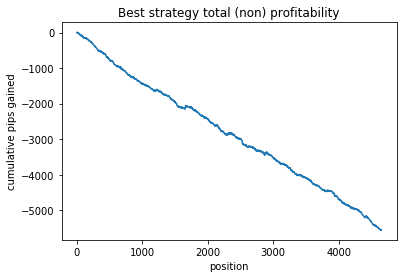

In [21]:
# plot!
cum_pips = [0]
for i, x in enumerate(to_plot):
    if i == 0:
        continue
    cum_pips.append(cum_pips[i-1] + x)
plt.plot(cum_pips)
plt.ylabel('cumulative pips gained')
plt.xlabel('position')
plt.title('Best strategy total (non) profitability')
plt.show()